In [1]:
import copy
import json
import numpy as np
import matplotlib.pyplot as plt

from utils import ConfigObject
from utils import reserve_pop
from utils import id_generator
from utils import writer
from utils import LibriSpeechGenerator

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
import torch.nn.functional as F

from parts import VSConvBlock
from parts import DownSamplingBlock
from parts import UpSamplingBlock
from parts import OutBlock

## Parameters

In [2]:
jsonConfig = {
    "test_platform": False,
    "ds_prop": 0.25,
    "sr": 16000,
    "n_samples": 65536,
    
    "n_channels": 1,
    "n_classes": 1,
    "depth": 5,
    "fsize": 24,
    "moffset": 8,
    
    "batch_size": 16,
    "epochs": 25,
    "shuffle": True,
    "num_workers": 8,
    "verbose": 100,

    "checkpoint_path": "../models/model_checkpoint.pt",
    "model_path": "../models/last_model.pt",

    "save_last_batch": True,
    "writer_path": "../logs/",
    "history_path": "../logs/history.json"
}

config = ConfigObject(**jsonConfig)

In [3]:
# Data Loaders
_params = {
    'batch_size': config.batch_size,
    'shuffle': config.shuffle,
    'num_workers': config.num_workers
}

## Import Data

In [4]:
X_train = torch.load("../data/processed/noisy/train/x_train.pt")
y_train = torch.load("../data/processed/noisy/train/y_train.pt")
X_train_ae = torch.load("../data/processed/aewi/val/val.pt")

X_train = torch.cat([X_train, X_train_ae])
y_train = torch.cat([y_train, X_train_ae])

In [5]:
import gc
del X_train_ae
gc.collect()

687

In [6]:
X_val = torch.load("../data/processed/noisy/val/x_val.pt")
y_val = torch.load("../data/processed/noisy/val/y_val.pt")

In [7]:
X_train.shape

torch.Size([36190, 1, 65536])

## Data Generators

In [8]:
# Data Generators
lsg = LibriSpeechGenerator(config, X_train, y_train)
lsg_val = LibriSpeechGenerator(config, X_val, y_val)

ls_generator = data.DataLoader(lsg, **_params)
ls_val_generator = data.DataLoader(lsg_val, **_params)

## Model

In [9]:
class SEWUNet(nn.Module):
    def __init__(self, config, fd=15, fu=5):
        """Speech Enhancenment using Wave-U-Net"""
        super(SEWUNet, self).__init__()

        # Hyperparameters
        self.n_channels = config.n_channels
        self.n_classes = config.n_classes
        self.depth = config.depth
        self.fsize = config.fsize
        self.moffset = config.moffset
        self.fd = fd
        self.fu = fu

        # Generate the list of in, out channels for the encoder
        self.enc_filters = [self.n_channels]
        self.enc_filters += [self.fsize * i + self.moffset
                             for i in range(1, self.depth + 1)]
        self.n_encoder = zip(self.enc_filters, self.enc_filters[1:])

        # Bottleneck block sizes
        mid_in = self.fsize * self.depth + self.moffset
        mid_out = self.fsize * (self.depth + 1) + self.moffset

        # Generate the list of in, out channels for the decoder
        self.out_dec = reserve_pop(self.enc_filters)
        self.in_dec = [mid_out + self.enc_filters[-1]]
        self.in_dec += [self.out_dec[i] + self.out_dec[i + 1]
                        for i in range(self.depth - 1)]
        self.n_decoder = zip(self.in_dec, self.out_dec)

        # Architecture and parameters
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()

        # Build the encoder part of the U-net architecture
        for i, (in_ch, out_ch) in enumerate(self.n_encoder):
            self.encoder.append(DownSamplingBlock(
                in_ch=in_ch,
                out_ch=out_ch,
                kernel_size=self.fd,
                padding=self.fd // 2,
                activation=nn.LeakyReLU(0.1))
            )

        # Bottleneck block for the U-net
        self.mid_block = VSConvBlock(
            in_ch=mid_in,
            out_ch=mid_out,
            kernel_size=self.fd,
            padding=self.fd // 2,
            activation=nn.LeakyReLU(0.1))

        # Build the decoder part of the U-net architecture
        for in_ch, out_ch in self.n_decoder:
            self.decoder.append(UpSamplingBlock(
                in_ch=in_ch,
                out_ch=out_ch,
                kernel_size=self.fu,
                padding=self.fu // 2,
                activation=nn.LeakyReLU(0.1))
            )

        # Output block
        out_ch = self.out_dec[-1] + 1
        self.out_block = OutBlock(
            in_ch=out_ch,
            out_ch=self.n_classes,
            activation=nn.Tanh()
        )

    def forward(self, x):
        """"""
        enc = []
        net_in = copy.copy(x)

        for i in range(self.depth):
            x, xi = self.encoder[i](x)
            enc.append(xi)

        x = self.mid_block(x)

        for i in range(self.depth):
            x = self.decoder[i](x, enc.pop())

        x = self.out_block(x, net_in)

        return x

## Trainer

In [10]:
# Training parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
history = {'loss': [], 'SNR': [], 'val_loss': [], 'val_SNR': []}

In [11]:
model = SEWUNet(config)

In [12]:
def CustomMetric():
    """Calculate the SNR of X and Y"""
    def SNR(X, Y):
        n = X.shape[2]
        return torch.mean(10 * torch.log10(
            (torch.norm(Y, dim=2)**2 / n) /
            (torch.norm(X - Y, dim=2)**2 / n)
        ))
    return SNR

In [13]:
# Build optimizer
optimizer = optim.Adam(
    model.parameters(),
    lr=3e-4,
    weight_decay=1e-6,
    betas=(0.9, 0.999))

# lr_scheduler = torch.optim.lr_scheduler(optimizer)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1)

# Loss and metric
m_loss = nn.L1Loss()
m_snr = CustomMetric()

# Print validation metric before trainer
print("SNR (Validation): {}".format(m_snr(lsg_val.X, lsg_val.y).item()))

SNR (Validation): 10.05069351196289


In [14]:
# Copy model to device
model = model.to(device)

In [15]:
checkpoint = torch.load('ae_checkpoint.pt')
model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

<All keys matched successfully>

In [16]:
# Calculate the number of trainable parameters in the model
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
sum([np.prod(p.size()) for p in model_parameters])

1139372

In [17]:
# Function to display trainning metrics
def _display_metrics(epoch, it, steps, loss, metric):
    print("Epoch [{:02d}/{:02d}]".format(
        epoch + 1, config.epochs), end=", ")

    print("Step [{:03d}/{:03d}]".format(
        it + 1, steps), end=", ")

    print("Loss: {}, SNR: {}".format(
        loss, metric))

In [18]:
# Train the model over epochs
steps = len(ls_generator)

for epoch in range(config.epochs):
    # training and val metrics for all data
    loss, metric = 0.0, 0.0
    val_loss, val_metric = 0.0, 0.0

    # ======================== Training ============================= #
    for i, (local_batch, local_labels) in enumerate(ls_generator):
        # Transfer to Device
        local_batch = local_batch.to(device)
        local_labels = local_labels.to(device)

        # Set gradient
        optimizer.zero_grad()

        # Forward pass, backward pass, optimize
        outputs = model(local_batch)
        loss_batch = m_loss(outputs, local_labels)
        batch_metric = m_snr(outputs, local_labels)
        loss_batch.backward()
        optimizer.step()

        # Compute metrics to all batch
        loss += loss_batch.item() * len(local_batch)
        metric += batch_metric.item() * len(local_batch)

        # Print the loss every "verbose" batches
        if (i + 1) % config.verbose == 0:
            _display_metrics(epoch, i, steps,
                loss_batch.item(), batch_metric.item())

    # Compute the statistics of the last epoch and save to history
    history['loss'].append(loss / len(lsg))
    history['SNR'].append(metric / len(lsg))

    # Checkpoint the model
    torch.save(model.state_dict(), config.checkpoint_path)
    
    # Print Validation statistics
    print(".:. Training metrics =", end=" ")
    print("Loss: {}, SNR: {}".format(loss / len(lsg), metric / len(lsg)))
    
    # ======================= Validation ============================ #
    with torch.no_grad():
        for local_batch, local_labels in ls_val_generator:
            # Transfer to device
            local_batch = local_batch.to(device)
            local_labels = local_labels.to(device)

            # Predict, get loss and metric
            outputs = model(local_batch)
            val_loss += m_loss(outputs, local_labels).item() \
                * len(local_batch)

            val_metric += m_snr(outputs, local_labels).item() \
                * len(local_batch)

        val_loss /= len(lsg_val)
        val_metric /= len(lsg_val)
                
    # Print Validation statistics
    print(".:. Validation metrics =", end=" ")
    print("Loss: {}, SNR: {}".format(val_loss, val_metric))

    # Compute the metrics and loss of last batch and save to history
    history['val_loss'].append(val_loss)
    history['val_SNR'].append(val_metric)
    lr_scheduler.step(val_loss)

Epoch [01/25], Step [100/2262], Loss: 0.010073499754071236, SNR: 13.109391212463379
Epoch [01/25], Step [200/2262], Loss: 0.00986173003911972, SNR: 12.67269515991211
Epoch [01/25], Step [300/2262], Loss: 0.022691166028380394, SNR: 11.14752197265625
Epoch [01/25], Step [400/2262], Loss: 0.009030519053339958, SNR: 12.903619766235352
Epoch [01/25], Step [500/2262], Loss: 0.010070573538541794, SNR: 12.481866836547852
Epoch [01/25], Step [600/2262], Loss: 0.010999556630849838, SNR: 12.59660530090332
Epoch [01/25], Step [700/2262], Loss: 0.010799899697303772, SNR: 11.850373268127441
Epoch [01/25], Step [800/2262], Loss: 0.00789535604417324, SNR: 12.189760208129883
Epoch [01/25], Step [900/2262], Loss: 0.010708009824156761, SNR: 10.975275993347168
Epoch [01/25], Step [1000/2262], Loss: 0.010711289010941982, SNR: 12.268896102905273
Epoch [01/25], Step [1100/2262], Loss: 0.007771109230816364, SNR: 13.66387939453125
Epoch [01/25], Step [1200/2262], Loss: 0.008450979366898537, SNR: 14.23357963562

Epoch [05/25], Step [300/2262], Loss: 0.006699901074171066, SNR: 16.129615783691406
Epoch [05/25], Step [400/2262], Loss: 0.005522642284631729, SNR: 18.157299041748047
Epoch [05/25], Step [500/2262], Loss: 0.007050966843962669, SNR: 15.01240348815918
Epoch [05/25], Step [600/2262], Loss: 0.005889163352549076, SNR: 17.474308013916016
Epoch [05/25], Step [700/2262], Loss: 0.00830416101962328, SNR: 15.535910606384277
Epoch [05/25], Step [800/2262], Loss: 0.008572682738304138, SNR: 13.882553100585938
Epoch [05/25], Step [900/2262], Loss: 0.006524287164211273, SNR: 15.850003242492676
Epoch [05/25], Step [1000/2262], Loss: 0.00660133920609951, SNR: 14.624847412109375
Epoch [05/25], Step [1100/2262], Loss: 0.005637154448777437, SNR: 16.440654754638672
Epoch [05/25], Step [1200/2262], Loss: 0.006839856971055269, SNR: 18.389530181884766
Epoch [05/25], Step [1300/2262], Loss: 0.005625124555081129, SNR: 16.06655502319336
Epoch [05/25], Step [1400/2262], Loss: 0.0059187086299061775, SNR: 18.453567

Epoch [09/25], Step [600/2262], Loss: 0.007341567426919937, SNR: 16.994487762451172
Epoch [09/25], Step [700/2262], Loss: 0.00582544133067131, SNR: 17.071685791015625
Epoch [09/25], Step [800/2262], Loss: 0.0060255806893110275, SNR: 15.844731330871582
Epoch [09/25], Step [900/2262], Loss: 0.005589403212070465, SNR: 18.758686065673828
Epoch [09/25], Step [1000/2262], Loss: 0.006331928074359894, SNR: 15.54908275604248
Epoch [09/25], Step [1100/2262], Loss: 0.007758882828056812, SNR: 17.465368270874023
Epoch [09/25], Step [1200/2262], Loss: 0.006142079830169678, SNR: 16.317689895629883
Epoch [09/25], Step [1300/2262], Loss: 0.006093543488532305, SNR: 15.429410934448242
Epoch [09/25], Step [1400/2262], Loss: 0.0050511229783296585, SNR: 17.637983322143555
Epoch [09/25], Step [1500/2262], Loss: 0.007165201939642429, SNR: 14.48163890838623
Epoch [09/25], Step [1600/2262], Loss: 0.004602330271154642, SNR: 19.954710006713867
Epoch [09/25], Step [1700/2262], Loss: 0.00665480550378561, SNR: 15.63

Epoch [13/25], Step [900/2262], Loss: 0.006610979791730642, SNR: 18.649799346923828
Epoch [13/25], Step [1000/2262], Loss: 0.006600207183510065, SNR: 18.255889892578125
Epoch [13/25], Step [1100/2262], Loss: 0.005626536440104246, SNR: 16.754438400268555
Epoch [13/25], Step [1200/2262], Loss: 0.00457048648968339, SNR: 18.250078201293945
Epoch [13/25], Step [1300/2262], Loss: 0.0052406685426831245, SNR: 16.890504837036133
Epoch [13/25], Step [1400/2262], Loss: 0.006856178864836693, SNR: 15.482704162597656
Epoch [13/25], Step [1500/2262], Loss: 0.0055589680559933186, SNR: 15.428620338439941
Epoch [13/25], Step [1600/2262], Loss: 0.004875805228948593, SNR: 18.4979248046875
Epoch [13/25], Step [1700/2262], Loss: 0.005078540183603764, SNR: 16.741992950439453
Epoch [13/25], Step [1800/2262], Loss: 0.0066548120230436325, SNR: 15.815057754516602
Epoch [13/25], Step [1900/2262], Loss: 0.004501631483435631, SNR: 18.65723419189453
Epoch [13/25], Step [2000/2262], Loss: 0.006561798043549061, SNR: 1

Epoch [17/25], Step [1100/2262], Loss: 0.00692654587328434, SNR: 17.748554229736328
Epoch [17/25], Step [1200/2262], Loss: 0.005021425895392895, SNR: 17.661378860473633
Epoch [17/25], Step [1300/2262], Loss: 0.005376808345317841, SNR: 17.63542366027832
Epoch [17/25], Step [1400/2262], Loss: 0.004745339974761009, SNR: 18.74362564086914
Epoch [17/25], Step [1500/2262], Loss: 0.0045410883612930775, SNR: 19.625911712646484
Epoch [17/25], Step [1600/2262], Loss: 0.006494068540632725, SNR: 16.195545196533203
Epoch [17/25], Step [1700/2262], Loss: 0.004622194916009903, SNR: 17.232704162597656
Epoch [17/25], Step [1800/2262], Loss: 0.0059006474912166595, SNR: 19.284696578979492
Epoch [17/25], Step [1900/2262], Loss: 0.006908899173140526, SNR: 16.168956756591797
Epoch [17/25], Step [2000/2262], Loss: 0.005187513306736946, SNR: 17.732669830322266
Epoch [17/25], Step [2100/2262], Loss: 0.005443971138447523, SNR: 17.757640838623047
Epoch [17/25], Step [2200/2262], Loss: 0.005663905758410692, SNR: 

Epoch [21/25], Step [1300/2262], Loss: 0.005319399759173393, SNR: 20.11300277709961
Epoch [21/25], Step [1400/2262], Loss: 0.004453950561583042, SNR: 20.915912628173828
Epoch [21/25], Step [1500/2262], Loss: 0.00525689497590065, SNR: 20.0122127532959
Epoch [21/25], Step [1600/2262], Loss: 0.006981964688748121, SNR: 16.411548614501953
Epoch [21/25], Step [1700/2262], Loss: 0.0028606238774955273, SNR: 20.950136184692383
Epoch [21/25], Step [1800/2262], Loss: 0.006278203800320625, SNR: 17.336807250976562
Epoch [21/25], Step [1900/2262], Loss: 0.004423447418957949, SNR: 17.218463897705078
Epoch [21/25], Step [2000/2262], Loss: 0.005362465046346188, SNR: 17.88842010498047
Epoch [21/25], Step [2100/2262], Loss: 0.004278725013136864, SNR: 18.799531936645508
Epoch [21/25], Step [2200/2262], Loss: 0.006455130409449339, SNR: 18.49901580810547
.:. Training metrics = Loss: 0.005431437176199587, SNR: 18.364933255088367
.:. Validation metrics = Loss: 0.006442160742306632, SNR: 15.51281491703093
Epoc

Epoch [25/25], Step [1600/2262], Loss: 0.003858492709696293, SNR: 19.056407928466797
Epoch [25/25], Step [1700/2262], Loss: 0.006728010252118111, SNR: 18.0033016204834
Epoch [25/25], Step [1800/2262], Loss: 0.0047414484433829784, SNR: 16.2210693359375
Epoch [25/25], Step [1900/2262], Loss: 0.004302086308598518, SNR: 19.2296199798584
Epoch [25/25], Step [2000/2262], Loss: 0.004512303974479437, SNR: 18.33623695373535
Epoch [25/25], Step [2100/2262], Loss: 0.005882935598492622, SNR: 18.77545166015625
Epoch [25/25], Step [2200/2262], Loss: 0.0051514324732124805, SNR: 17.896934509277344
.:. Training metrics = Loss: 0.005421813032284902, SNR: 18.382419522831736
.:. Validation metrics = Loss: 0.006433615310985129, SNR: 15.519936502310877


In [19]:
# Save the last model
torch.save(model.state_dict(), config.model_path)

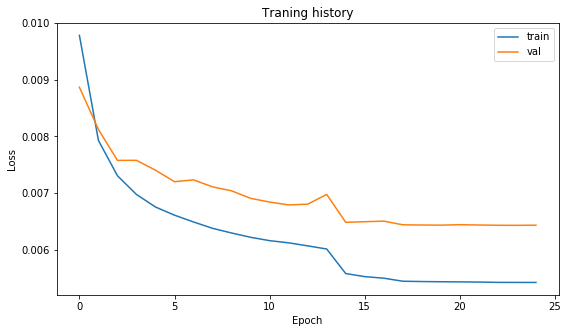

In [20]:
# Plot network history
plt.figure(figsize=(9,5))
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Traning history')
plt.legend()
plt.show()

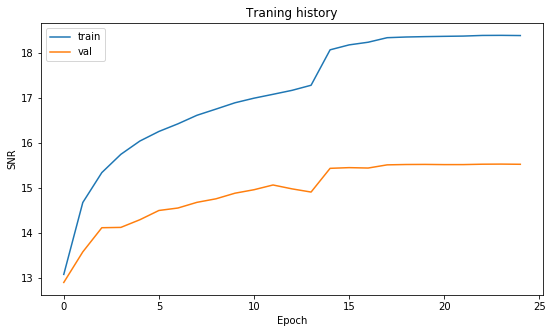

In [21]:
# Plot network history
plt.figure(figsize=(9,5))
plt.plot(history['SNR'], label='train')
plt.plot(history['val_SNR'], label='val')
plt.ylabel('SNR')
plt.xlabel('Epoch')
plt.title('Traning history')
plt.legend()
plt.show()

In [22]:
# Save history to a JSON file
with open(config.history_path, 'w') as fp:
    json.dump(history, fp)

## Test

In [23]:
X_test = torch.load("../data/processed/noisy/test/x_test.pt")
y_test = torch.load("../data/processed/noisy/test/y_test.pt")

In [24]:
lsg_test = LibriSpeechGenerator(config, X_test, y_test)
ls_test_generator = data.DataLoader(lsg_test, **_params)

In [25]:
X_test.shape

torch.Size([3874, 1, 65536])

In [26]:
# Print validation metric before trainer
print("SNR (Test): {}".format(m_snr(lsg_test.X, lsg_test.y).item()))

SNR (Test): 10.058753967285156


In [27]:
test_loss, test_metric = 0.0, 0.0
with torch.no_grad():
    for local_batch, local_labels in ls_test_generator:
        # Transfer to device
        local_batch = local_batch.to(device)
        local_labels = local_labels.to(device)

        # Predict, get loss and metric
        outputs = model(local_batch)
        test_loss += m_loss(outputs, local_labels).item() \
            * len(local_batch)

        test_metric += m_snr(outputs, local_labels).item() \
            * len(local_batch)
        
        writer(local_batch, local_labels,
               outputs, config.sr, config.writer_path)

    test_loss /= len(lsg_test)
    test_metric /= len(lsg_test)

In [28]:
import os

test_history = {
    'SNR_ini': m_snr(lsg_test.X, lsg_test.y).item(),
    'SNR': test_metric, 
    'loss': test_loss
}

# with open(os.path.join(config.writer_path, 'test_history.json') , 'w') as fp:
#     json.dump(test_history, fp)

In [29]:
test_history

{'SNR_ini': 10.058753967285156,
 'SNR': 15.73345841214284,
 'loss': 0.006422024996731013}

In [30]:
%%time
with torch.no_grad():
    for local_batch, local_labels in ls_test_generator:
        # Transfer to device
        local_batch = local_batch.to(device)
        local_labels = local_labels.to(device)

        # Predict, get loss and metric
        outputs = model(local_batch)

CPU times: user 21.4 s, sys: 1.25 s, total: 22.6 s
Wall time: 23.1 s


In [32]:
X_test.shape

torch.Size([3874, 1, 65536])

In [33]:
23.1/3874

0.005962829117191534

In [ ]:
0.006

In [35]:
model = model.to("cpu")

In [36]:
%%time
with torch.no_grad():
    for local_batch, local_labels in ls_test_generator:
        # Transfer to device
        local_batch = local_batch.to("cpu")
        local_labels = local_labels.to("cpu")

        # Predict, get loss and metric
        outputs = model(local_batch)

CPU times: user 37min 43s, sys: 5min 35s, total: 43min 18s
Wall time: 17min 30s


In [ ]:
/3874